# LFM

In [10]:
import os
import sys

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import (
    precision_at_k, recall_at_k)

from recommenders.evaluation.python_evaluation import get_top_k_items, map_at_k, ndcg_at_k, precision_at_k, recall_at_k, diversity, novelty, distributional_coverage, catalog_coverage 
from recommenders.tuning.parameter_sweep import generate_param_grid

from lightfm.evaluation import precision_at_k as lightfm_prec_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.6.13 | packaged by conda-forge | (default, Sep 23 2021, 07:55:15) 
[GCC Clang 11.1.0]
LightFM version: 1.16


In [11]:
#utils

# results table
cols = ["Data", "Algo", "K", "Train time (s)","Predicting time (s)", "RMSE", "MAE", "R2", "Explained Variance", "Recommending time (s)", "MAP", "nDCG@k", "Precision@k", "Recall@k","Diversity","Novelty","Distributional coverage","Catalog coverage"]
df_results = pd.DataFrame(columns=cols)

def generate_summary(data, algo, k, train_time, rating_time, rating_metrics, ranking_time, ranking_metrics, diversity_metrics):
    summary = {"Data": data, "Algo": algo, "K": k, "Train time (s)": train_time, "Predicting time (s)": rating_time, "Recommending time (s)":ranking_time}
    if rating_metrics is None:
        rating_metrics = {
            "RMSE": np.nan,
            "MAE": np.nan,
            "R2": np.nan,
            "Explained Variance": np.nan,
        }
    if ranking_metrics is None:
        ranking_metrics = {
            "MAP": np.nan,
            "nDCG@k": np.nan,
            "Precision@k": np.nan,
            "Recall@k": np.nan,
        }
    if diversity_metrics is None:
        diversity_metrics = {
        "Diversity": np.nan,
        "Novelty": np.nan,
        "Distributional coverage": np.nan,
        "Catalog coverage": np.nan,
    }
    summary.update(diversity_metrics)
    summary.update(rating_metrics)
    summary.update(ranking_metrics)

    return summary


def convert_timestamp(datetime):
    date_string = str(datetime)
    date = datetime.datetime.strptime(date_string, "%m/%d/%Y")
    timestamp = datetime.datetime.timestamp(date)
    return(timestamp)

def preprocess_data(df):
    # need to change the col name because the function created by MSFT are hard-coded
    # Convert the float precision to 32-bit in order to reduce memory consumption 
    df.loc[:, header["col_rating"]] = df[header["col_rating"]].astype(np.float32)
    df = df[[header["col_user"],header["col_item"],header["col_rating"]]]
    df = df.rename(columns={header["col_user"]: "userID", header["col_item"]: "itemID",header["col_rating"]:"rating"})
    return df 

def predict_and_calculate_metrics(svd,test):
    predictions = predict(svd, test, usercol=header["col_user"], itemcol=header["col_item"])
    eval_rmse = rmse(test, predictions, 
                     col_user = header["col_user"],
                     col_item = header["col_item"],
                     col_rating = header["col_rating"],
                     col_prediction = header["col_prediction"]
                    )
    return(eval_rmse)
    

# 0. Config params

In [12]:
# table results 
algo = "lfm"
ranking_metrics = None
rating_metrics = None
diversity_metrics = None
train_time = np.nan
rating_time = np.nan
ranking_time = np.nan

# column name 
header = {
    "col_user": "customer_id",
    "col_item": "variant_id",
    "col_rating": "quantity",
    "col_timestamp": "order_date",
    "col_prediction": "prediction",
}

# top k
TOP_K = 10

################ TO MODIFY ################

# date size with 3 choices : "100k","1M" and "all"
data_size = "1M"

# load splitted data 
load_splitted_data = True 

################ TO MODIFY ################

# 1. Data

# 1.1 Load data 

In [13]:
########### TO MODIFY ###########
def load_data(data_size):
    path = ""
    if data_size=="100k":
        path = '../../data/transaction_100k_df.pkl'
    elif data_size=="1M":
        path = '../../data/transaction_1M_df.pkl'
    elif data_size=="all":
        path = '../../data/transaction_all_df.pkl'
    
    if path != "":
        return pd.read_pickle(path)
    else :
        print("Please choose between 100k, 1M and all")
########### TO MODIFY ###########

## 1.2 Split data

In [14]:
# 2 ways to load the data
if not load_splitted_data : 
    # data not splitted 
    data = load_data(data_size)
else :
    data = load_data(data_size)
    # or  use stored splitted data to make it faster
    train = pd.read_pickle(f"../../data/train_{data_size}_df.pkl")
    test = pd.read_pickle(f"../../data/test_{data_size}_df.pkl")
    train.shape[0], test.shape[0]

In [15]:
# chrono split but it is really slow ( +1h to split 8M data ) 
if not load_splitted_data :
    train, test = python_chrono_split(data,
                                      ratio=0.75,
                                      col_user=header["col_user"],
                                      col_item=header["col_item"],
                                      col_timestamp = header["col_timestamp"]
                                     )
    train.to_pickle(f"../../data/train_{data_size}_df.pkl")
    test.to_pickle(f"../../data/test_{data_size}_df.pkl")
    train.shape[0], test.shape[0]

## 1.3 Process data

In [16]:
data = preprocess_data(data)
train = preprocess_data(train)
test = preprocess_data(test)

In [17]:
dataset = Dataset()
dataset.fit(users=data["userID"], 
            items=data["itemID"])

(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)
(train_interactions, train_weights) = dataset.build_interactions(train.iloc[:, 0:3].values)
(test_interactions, test_weights) = dataset.build_interactions(test.iloc[:, 0:3].values)

## 1.3 Split data 

LightLM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [18]:
#train_interactions, test_interactions = cross_validation.random_train_test_split(
#    interactions, test_percentage=TEST_PERCENTAGE,
#    random_state=np.random.RandomState(42))
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (23079, 7259)
Shape of test interactions: (23079, 7259)


# 2. Model

In [19]:
# model learning rate
LEARNING_RATE = 0.01
# no of latent factors
NO_COMPONENTS = 60
# no of epochs to fit model
NO_EPOCHS = 500
# no of threads to fit model
NO_THREADS = 4

In [20]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(42))

## 2.2 Train model

In [21]:
with Timer() as train_time:
    model1.fit(interactions=train_interactions,
              epochs=NO_EPOCHS,verbose = True);

Epoch: 100%|██████████| 500/500 [23:23<00:00,  2.81s/it]


## 2.4  recommend k items

In [22]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

In [ ]:
with Timer() as ranking_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)

In [ ]:
top_k = get_top_k_items(all_predictions,col_user="userID", col_rating="prediction",k=TOP_K)

# 3. Evaluate

## 3.2 Ranking metrics 

In [ ]:
args = [test, top_k]

kwargs = dict(relevancy_method = 'top_k', 
              k = TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)
    
ranking_metrics = {
    "MAP": eval_map,
    "nDCG@k": eval_ndcg,
    "Precision@k": eval_precision,
    "Recall@k": eval_recall
}

print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}",sep='\n')

## 3.3 Diversity metrics

In [ ]:
args = [train, top_k]

kwargs = dict(col_user = "userID",
              col_item = "itemID",
             )

eval_diversity = diversity(*args, **kwargs)
eval_novelty = novelty(*args, **kwargs)
eval_distributional_coverage = distributional_coverage(*args, **kwargs)
eval_catalog_coverage = catalog_coverage(*args,**kwargs)

diversity_metrics = {
    "Diversity": eval_diversity,
    "Novelty": eval_novelty,
    "Distributional coverage": eval_distributional_coverage,
    "Catalog coverage": eval_catalog_coverage,
}

print(f"Model:",
      f"Diversity :\t\t\t {eval_diversity}",
      f"Novelty:\t\t\t {eval_novelty:f}",
      f"Catalog coverage:\t\t {eval_catalog_coverage:f}",
      f"Distributional coverage:\t {eval_distributional_coverage:f}",sep='\n')

# 4 Summary

In [ ]:
summary = generate_summary(data_size,
                           algo,
                           TOP_K,
                           train_time, 
                           rating_time,
                           rating_metrics,
                           ranking_time,
                           ranking_metrics,
                           diversity_metrics)
df_results.loc[df_results.shape[0] + 1] = summary
df_results

# 5 Search

In [28]:
# search for best param
def search_param():
    param_dict = {
        "no_components": [5,10,20,40,60,80,100,200,300,500,1000],
        "learning_rate": [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1],
    }
    param_grid = generate_param_grid(param_dict)
    precision_score = []
    uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

    for g in tqdm(param_grid):
        model = LightFM(loss='warp',              
                         random_state=np.random.RandomState(42),
                         **g
                        )
        
        model.fit(interactions=train_interactions,
                   epochs=500
                 )

        #all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
        #                                          interactions=train_interactions,
        #                                          model=model, 
        #                                          num_threads=4)

        #args = [test, all_predictions]

        #kwargs = dict(relevancy_method = 'top_k', 
        #              k = TOP_K)
        
        eval_precision_lfm = lightfm_prec_at_k(model, test_interactions, 
                                       train_interactions, k=TOP_K).mean()
        
        #eval_precision = precision_at_k(*args, **kwargs)

        precision_score.append(eval_precision_lfm)
    
    return precision_score

def show_plot(precision_score):
    param_dict = {
        "no_components": [5,10,20,40,60,80,100,200,300,500,1000],
        "learning_rate": [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1],
    }
    precision_score = [float('%.4f' % x) for x in precision_score]
    precision_score_array = np.reshape(precision_score, (len(param_dict["no_components"]), len(param_dict["learning_rate"]))) 
    precision_score_df = pd.DataFrame(data=precision_score_array, index=pd.Index(param_dict["no_components"], name="no_components"), 
                           columns=pd.Index(param_dict["learning_rate"], name="learning_rate"))
    fig, ax = plt.subplots()
    sns.heatmap(precision_score_df, cbar=False, annot=True, fmt=".4g")

In [29]:
score = search_param()

  0%|          | 0/99 [00:00<?, ?it/s]

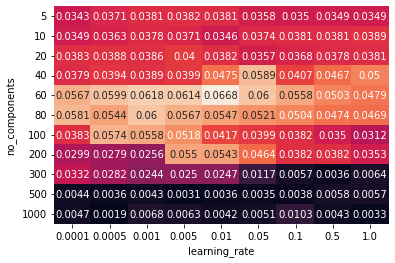

In [30]:
show_plot(score)